## Assignment 7: Regularization

#### Introduction

**Goal:** 
Use regularized linear modelling methods such as Lasso an Elastic Net, train on the FWHM value of first diffraction peak of three of the tertiary systems comprised of Co, Ti, Cr, and Zr, then the model is used to predict the FWHM over the entire quaternary space.

**Approach:** 
1. Perform LassoCV, where an optimal alpha that minimizes validation error is identified.
2. At the optimal alpha, features with coefficient of zero is removed from the feature set.

Then an Elastic Net model is fit onto the remaining features
1. Use ElasticNetCV to tune the alpha value
2. Train on the entire trainingset, with only features kept from the previous step
3. Compare the prediction to the prediction from Assignment 5, where no regularization was applied.

Note for myself:

Q: how do I provide the labels if I use stratified Shuffle split inside a pipeline?

Q: What is behind the pipeline? I pipelined StandardScaler with LassoCV, let it do a bunch of things, replace LassoCV with Lasso, let it do the same thing (e.g. report validation score) and the validation score is identical.

Q: if the alpha value is tuned on the entire dataset, does it constitutes dataleakage when the tuned alpha is used for validation?

In [1]:
import numpy as np
import numpy.matlib as nm
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import seaborn as sb

# pip install mpcontribs-client
from pymatgen.ext.matproj import MPRester

### 1. Import data, perform basic data cleaning.

* check what the FWHM distribution is like in the phase diagrams

* featureize dataset

* drop less meaningful columns (such as 1 column of zeros)

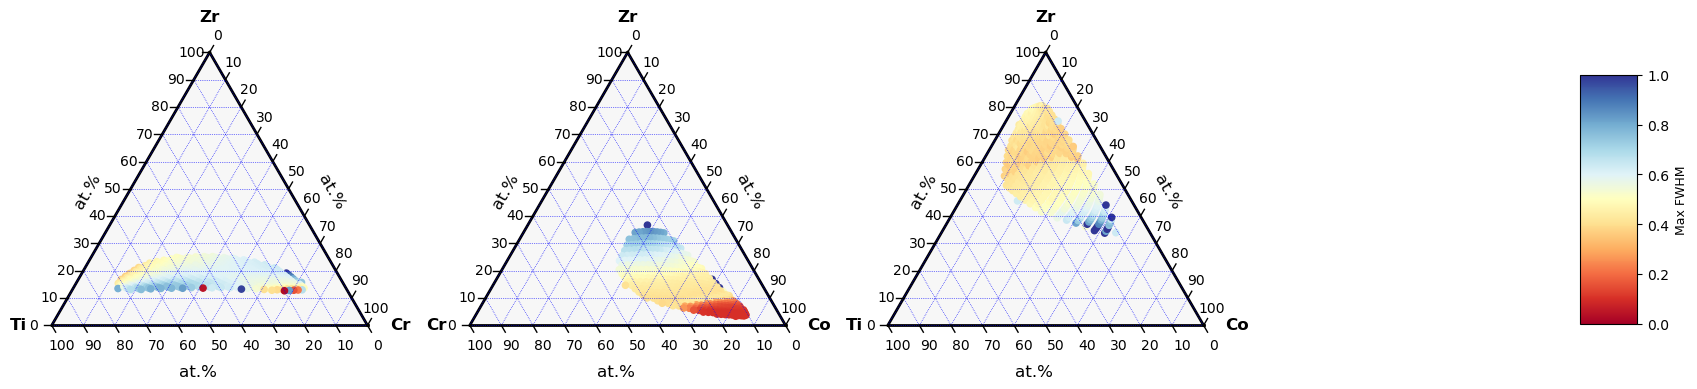

In [2]:
from CustomFunctions import df_plot_ternary

### same code as in Assignment 6, with minor improvement to make it concise
sheets = ['CrTiZr', 'CrCoZr', 'CoTiZr']
missing = ['Co', 'Ti', 'Cr']

fig, axs = plt.subplots(1, 4, figsize = (17, 4))
fig.tight_layout(pad = 2.0)

# create an empty dataframe with column names ['Co', 'Ti', 'Cr', 'Zr', 'MaxFWHM']
df = pd.DataFrame(columns = ['Co', 'Ti', 'Cr', 'Zr'])
### my own forloop
for i, e in enumerate(missing):
    sheet_df = pd.read_excel('Metallic Glass Data.xlsx', sheet_name = sheets[i]).dropna()
    
    # plotting 
    ax = axs[i]
    df_plot_ternary(sheet_df, sheet_df.loc[:, 'MaxFWHM'], 'Max FWHM', ax = ax, cmap = plt.cm.RdYlBu)
    
    #
    sheet_df[missing[i]] = 0
    sheet_df['tert_label'] = i
    df = pd.concat([df, sheet_df], ignore_index = True)

In [3]:
### featurize composition
dff = df.copy()
dff.insert(0, 'formula', 
           'Co' + dff['Co'].astype(str) + 'Ti' + dff['Ti'].astype(str) + 
           'Cr' + dff['Cr'].astype(str) + 'Zr' + dff['Zr'].astype(str))

# from matminer.featurizers.conversions import StrToComposition
# dff = StrToComposition().featurize_dataframe(dff, 'formula')

In [4]:
# from matminer.featurizers.composition import Miedema, Meredig, WenAlloys, AtomicPackingEfficiency, ElectronegativityDiff
# from matminer.featurizers.composition import BandCenter, TMetalFraction, CohesiveEnergyMP, IonProperty

# dff = AtomicPackingEfficiency().featurize_dataframe(dff, col_id='composition')
# dff = Miedema().featurize_dataframe(dff, col_id='composition')
# dff = Meredig().featurize_dataframe(dff, col_id='composition')
# dff = WenAlloys().featurize_dataframe(dff, col_id='composition')

# dff = BandCenter().featurize_dataframe(dff, col_id='composition')
# dff = TMetalFraction().featurize_dataframe(dff, col_id='composition')

# dff.to_excel('dff.xlsx', index = False)

In [5]:
dff = pd.read_excel('dff.xlsx')
Yang_df = dff[['Yang delta', 'Yang omega']]

print('before dropping there are ', dff.shape[1] - 8, ' features')

# drop the rows with nan
dff = dff.dropna()
# drop the column if the entire column is 0
dff = dff.loc[:, (dff != 0).any(axis=0)]

before dropping there are  155  features


### 2. Use LassoCV to perform feature selection

NEXT: 

* use StratifiedShuffleSplit() to ensure every fold has a bit of CoTiZr, TiCrZr...etc

* standardize X with .fit_transform X_train and .transform X_test

* in each fold, train Lasso (selecte a range of alphas to try), and let it predict. Report the MSE between y_test and y_hat. (How do I decide on which alpha is optimal, if optimal alpha from each fold is reported? average?)

In [6]:
features = dff.iloc[:, 8:]

# drop the non-numerical columns from the dataframe
non_numeric_cols = features.select_dtypes(exclude='number').columns
features = features.drop(columns=non_numeric_cols)

# define X and y
# X is the everything in dff after 'composition'
X = features.values
y = dff.loc[:, 'MaxFWHM'].values
label = dff.loc[:, 'tert_label'].values

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import ShuffleSplit, cross_val_score, KFold

'''SELECT ONE TO COMMENT OUT'''
ss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

alphas = np.logspace(-3, 0, 200)
pipeline = make_pipeline(StandardScaler(), 
                               LassoCV(alphas = alphas, cv=ss, tol = 0.1, fit_intercept=True)
                               ).fit(X, y)

lasso = pipeline[-1]
alpha_opt = lasso.alpha_
coefs = lasso.coef_.ravel()

# get the cross validation score
score = cross_val_score(pipeline, X, y, cv=ss)
print('Optimal alpha at: ', alpha_opt,
      '\nCross validation score: ', score)

Optimal alpha at:  0.001 
Cross validation score:  [0.69277768 0.68553233 0.6943244  0.68262659 0.71455506]


With the above code, suspect something is wrong because opt_alpha is **always** the lower bound, even after changing the lower bound to 1e-10. But the reason is not known at the moment.

BUT we can investigate a bit more. In the below graph, negative alphas (though shouldnt be used in reality) is used to investigate. It does appear that error is lowest at exactly alpha = 0

/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5657470453368543, tolerance: 2.3534541711589134
  model = cd_fast.enet_coordinate_descent_gram(
/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3562359631639067, tolerance: 2.3534541711589134
  model = cd_fast.enet_coordinate_descent_gram(
/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6176762614360256, tolerance: 2.3534541711589134
  model = cd_fast.enet_coordinate_descent_gram(
/Users/baishipu/opt/anaconda3/lib/python3.9

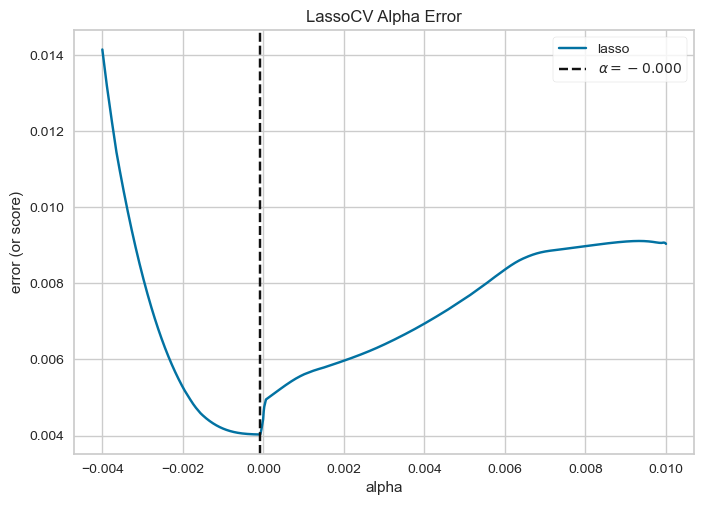

<AxesSubplot:title={'center':'LassoCV Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>

In [8]:
# just curious, let's visualize how error changes with alpha. Code learned from 
# https://www.scikit-yb.org/en/latest/api/regressor/alphas.html
# !pip install yellowbrick
from yellowbrick.regressor import AlphaSelection

# tranforming the entire X leads t data leakage, but this is just for plotting
X_std = StandardScaler().fit_transform(X)

# define lasso and pipline
alphas = np.linspace(-0.004, 0.01, 1000)
model = LassoCV(alphas=alphas, cv=ss, tol = 0.1, max_iter = 1000)
visualizer = AlphaSelection(model)
visualizer.fit(X_std, y)
visualizer.show()

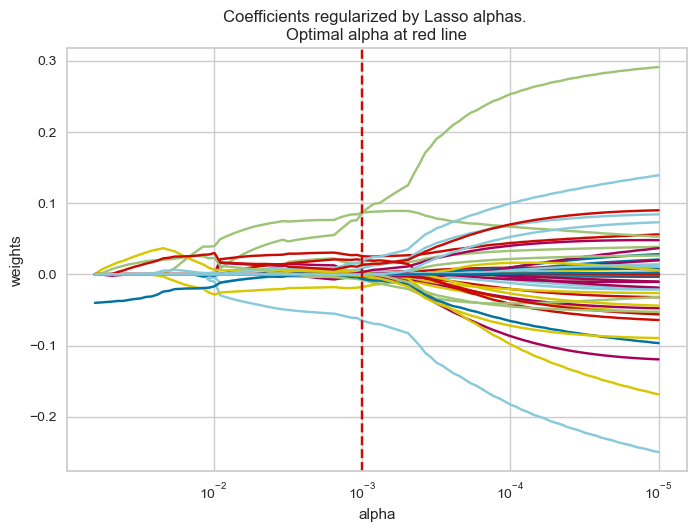

In [9]:
alphas = np.logspace(-5, -1.2, 100)

coefs = []
for a in alphas:

    lasso = Lasso(alpha=a, tol = 0.1, warm_start=False)
    pipline2 = make_pipeline(StandardScaler(), lasso).fit(X, y)

    coefs.append(pipline2[-1].coef_.ravel())

# Display results. Below codes borrowed from PRA
ax = plt.gca()
ax.plot(alphas, coefs)
plt.xlabel("alpha")
plt.ylabel("weights")
ax.set_xlim(ax.get_xlim()[::-1]); 
ax.set_xscale("log")
plt.title("Coefficients regularized by Lasso alphas. \nOptimal alpha at red line")
plt.axis("tight")
# plot a vertical line at the optimal alpha
plt.axvline(x=alpha_opt, color='r', linestyle='--')

plt.grid(True)
plt.show()

It also appear that setting different **'tol ='** changes the path graph above, with higher tol values making a bell-shape curve where coefficients are rapidly squashed to zero.

Next, we make a new df: **features_reduced**, which contains the features that have non-zero coefficients.

In [10]:
# get the coefficient when optimal alpha is used
lasso = Lasso(alpha=alpha_opt, tol = 0.1, warm_start=False)
pipline2 = make_pipeline(StandardScaler(), lasso).fit(X, y)
coef = pipline2[-1].coef_.ravel()

In [11]:
# in features, drop the columns which corresponds to 0 coefficients in coef
features_reduced = features.iloc[:, coef != 0]

# Just curious, take a look at the features filtered out by Lasso
lost = features.iloc[:, coef == 0].columns
print(list(lost), '\n\nTOTAL NUMBER DROPPED: ', len(lost))

['Miedema_deltaH_amor', 'mean AtomicWeight', 'mean Row', 'mean Number', 'frac s valence electrons', 'frac d valence electrons', 'APE mean', 'Electronegativity delta', 'Mixing enthalpy', 'Mean cohesive energy', 'Interant electrons', 'Interant d electrons', 'Shear modulus mean', 'Shear modulus delta', 'transition metal fraction'] 

TOTAL NUMBER DROPPED:  15


Interesting decision on which features to keep. Seems like some that were considered useful are dropped (Electronegativity delta), while some other useful ones (Yang omega) are not dropped.

Now we will move on to the next step: 

* fit Model (Ridge or Lasso) with only the remaining features
* in each fold, make it predict
* in each fold, compare predicted value vs actual value in a parity plot

In [12]:
from sklearn.linear_model import ElasticNetCV

X2 = features_reduced.values

# use the remaining features to do another ElasticNetCV
std = StandardScaler()
alphas = np.linspace(0, 5e-4, 1000)
ENCV = ElasticNetCV(alphas = alphas, cv=ss, fit_intercept=True)

# make pipeline again
pipeline2 = make_pipeline(std, ENCV).fit(X2, y)

# get the alpha and score
alpha_opt2 = pipeline2[-1].alpha_
score2 = cross_val_score(pipeline2, X2, y, cv=ss)

/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09997501253375507, tolerance: 0.0023534541711589135
  model = cd_fast.enet_coordinate_descent_gram(
/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015920217962498207, tolerance: 0.0023534541711589135
  model = cd_fast.enet_coordinate_descent_gram(
/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002923708547023729, tolerance: 0.0023534541711589135
  model = cd_fast.enet_coordinate_descent_gram(
/Users/baishipu/opt/anaconda3

/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.33800998608669364, tolerance: 0.23534541711589135
  model = cd_fast.enet_coordinate_descent_gram(
/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3004283454208956, tolerance: 0.23534541711589135
  model = cd_fast.enet_coordinate_descent_gram(
/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.32082436409309123, tolerance: 0.23534541711589135
  model = cd_fast.enet_coordinate_descent_gram(
/Users/baishipu/opt/anaconda3/lib/pyth

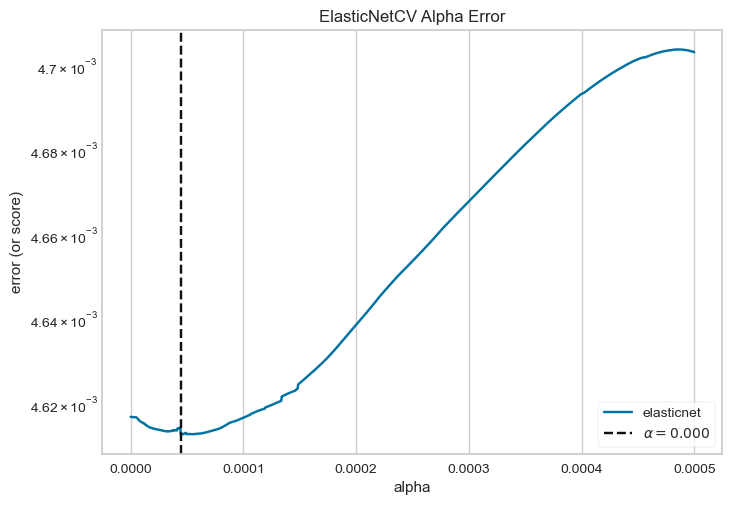

Optimal alpha:  4.754754754754754e-05


In [13]:
# let's see the how did alpha converge again

# tranforming the entire X leads t data leakage, but this is just for plotting
X2_std = StandardScaler().fit_transform(X2)

# define lasso and pipline
alphas = np.linspace(0, 5e-4, 1000)
ENCV = ElasticNetCV(alphas = alphas, cv=ss, tol=0.01, fit_intercept=True)
visualizer = AlphaSelection(ENCV)
visualizer.fit(X2_std, y)
# set y to log scale
visualizer.ax.set_yscale('log')
# visualizer.ax.set_xscale('log')
visualizer.show()

print('Optimal alpha: ', alpha_opt2)

Good convergence, the dashed line indicating optimal alpha (from the yellowbrick package) agrees with the one from ElasticNetCV

It is worth noting that this pacakge is not perfect - the graphing indicates that the error plateau at ~0.00035, but that is not the case i. Also the number was so small that alpha value in the legend does not display it properly.

### 3. Fit another regularized linear model on the entire training set. Here ElasticNet is used.

/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.142e+00, tolerance: 2.353e-02
  model = cd_fast.enet_coordinate_descent(
/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.379e+00, tolerance: 2.416e-02
  model = cd_fast.enet_coordinate_descent(
/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing reg

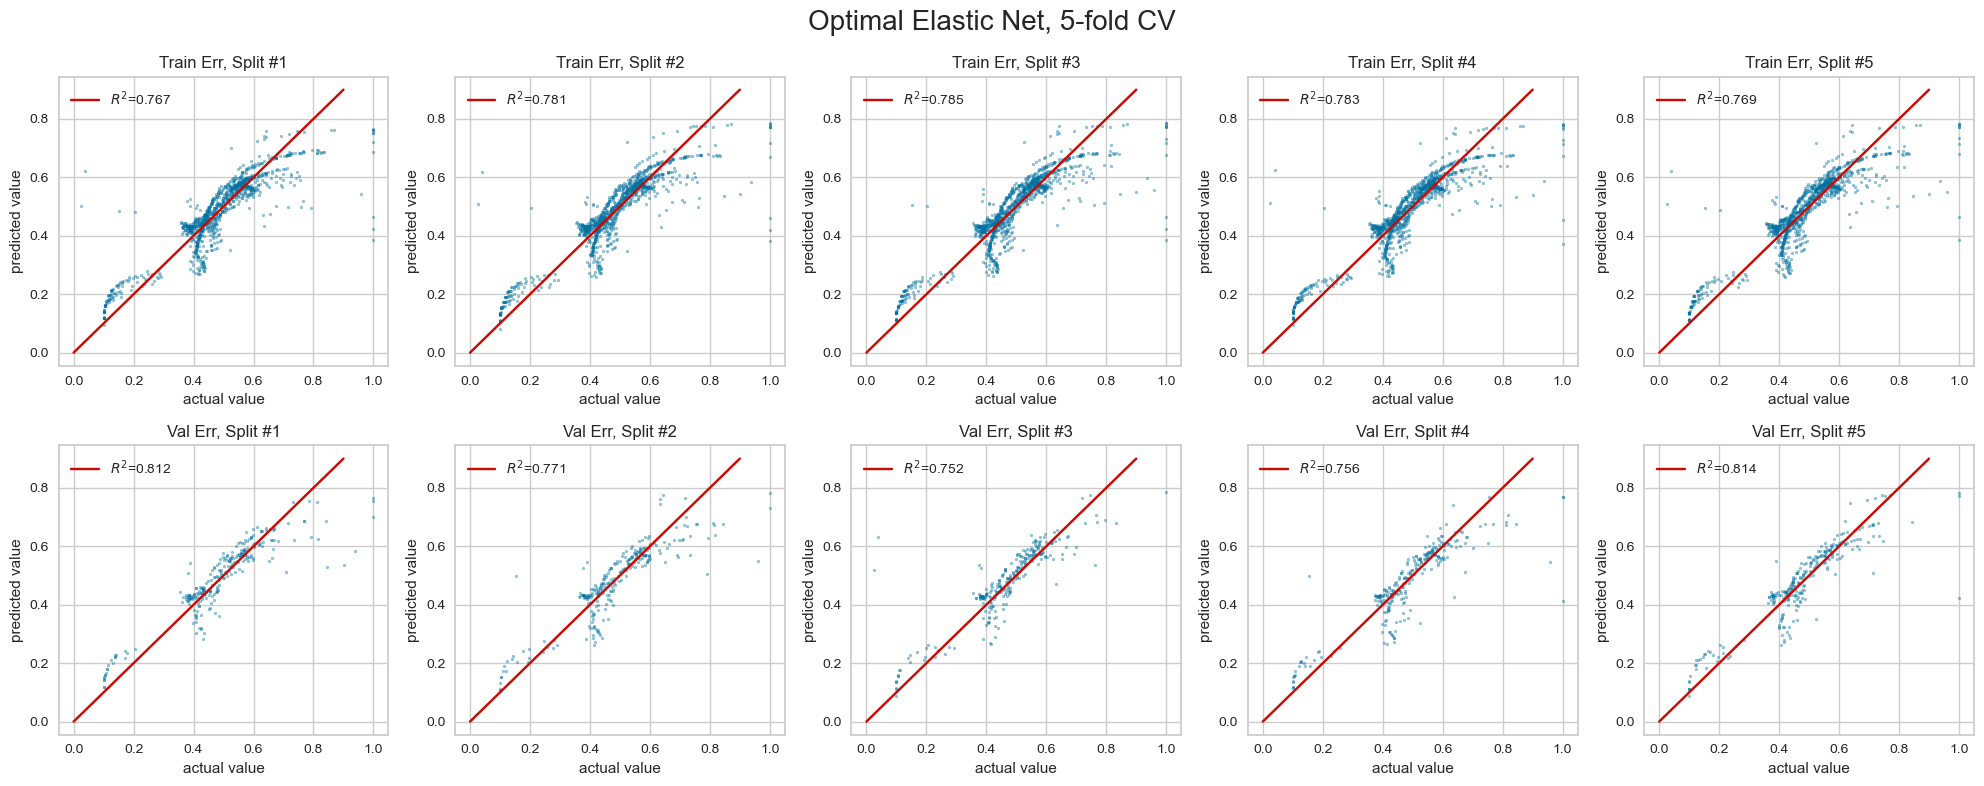

In [14]:
from sklearn.linear_model import ElasticNet
# make a elastic net model with the optimal alpha
EN = ElasticNet(alpha=alpha_opt2, tol = 0.001, fit_intercept=True)

from sklearn.model_selection import StratifiedShuffleSplit, LeaveOneGroupOut
from CustomFunctions import parity_plotCV

# define the split
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

# reminder that label used below are based on the ternary system it is in. the labels are 0, 1, 2
parity_plotCV(EN, X2, y, ss, cv_label=label ,title = 'Optimal Elastic Net, 5-fold CV')

/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.020e+00, tolerance: 2.298e-02
  model = cd_fast.enet_coordinate_descent(
/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.572e-01, tolerance: 1.095e-02
  model = cd_fast.enet_coordinate_descent(
/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing reg

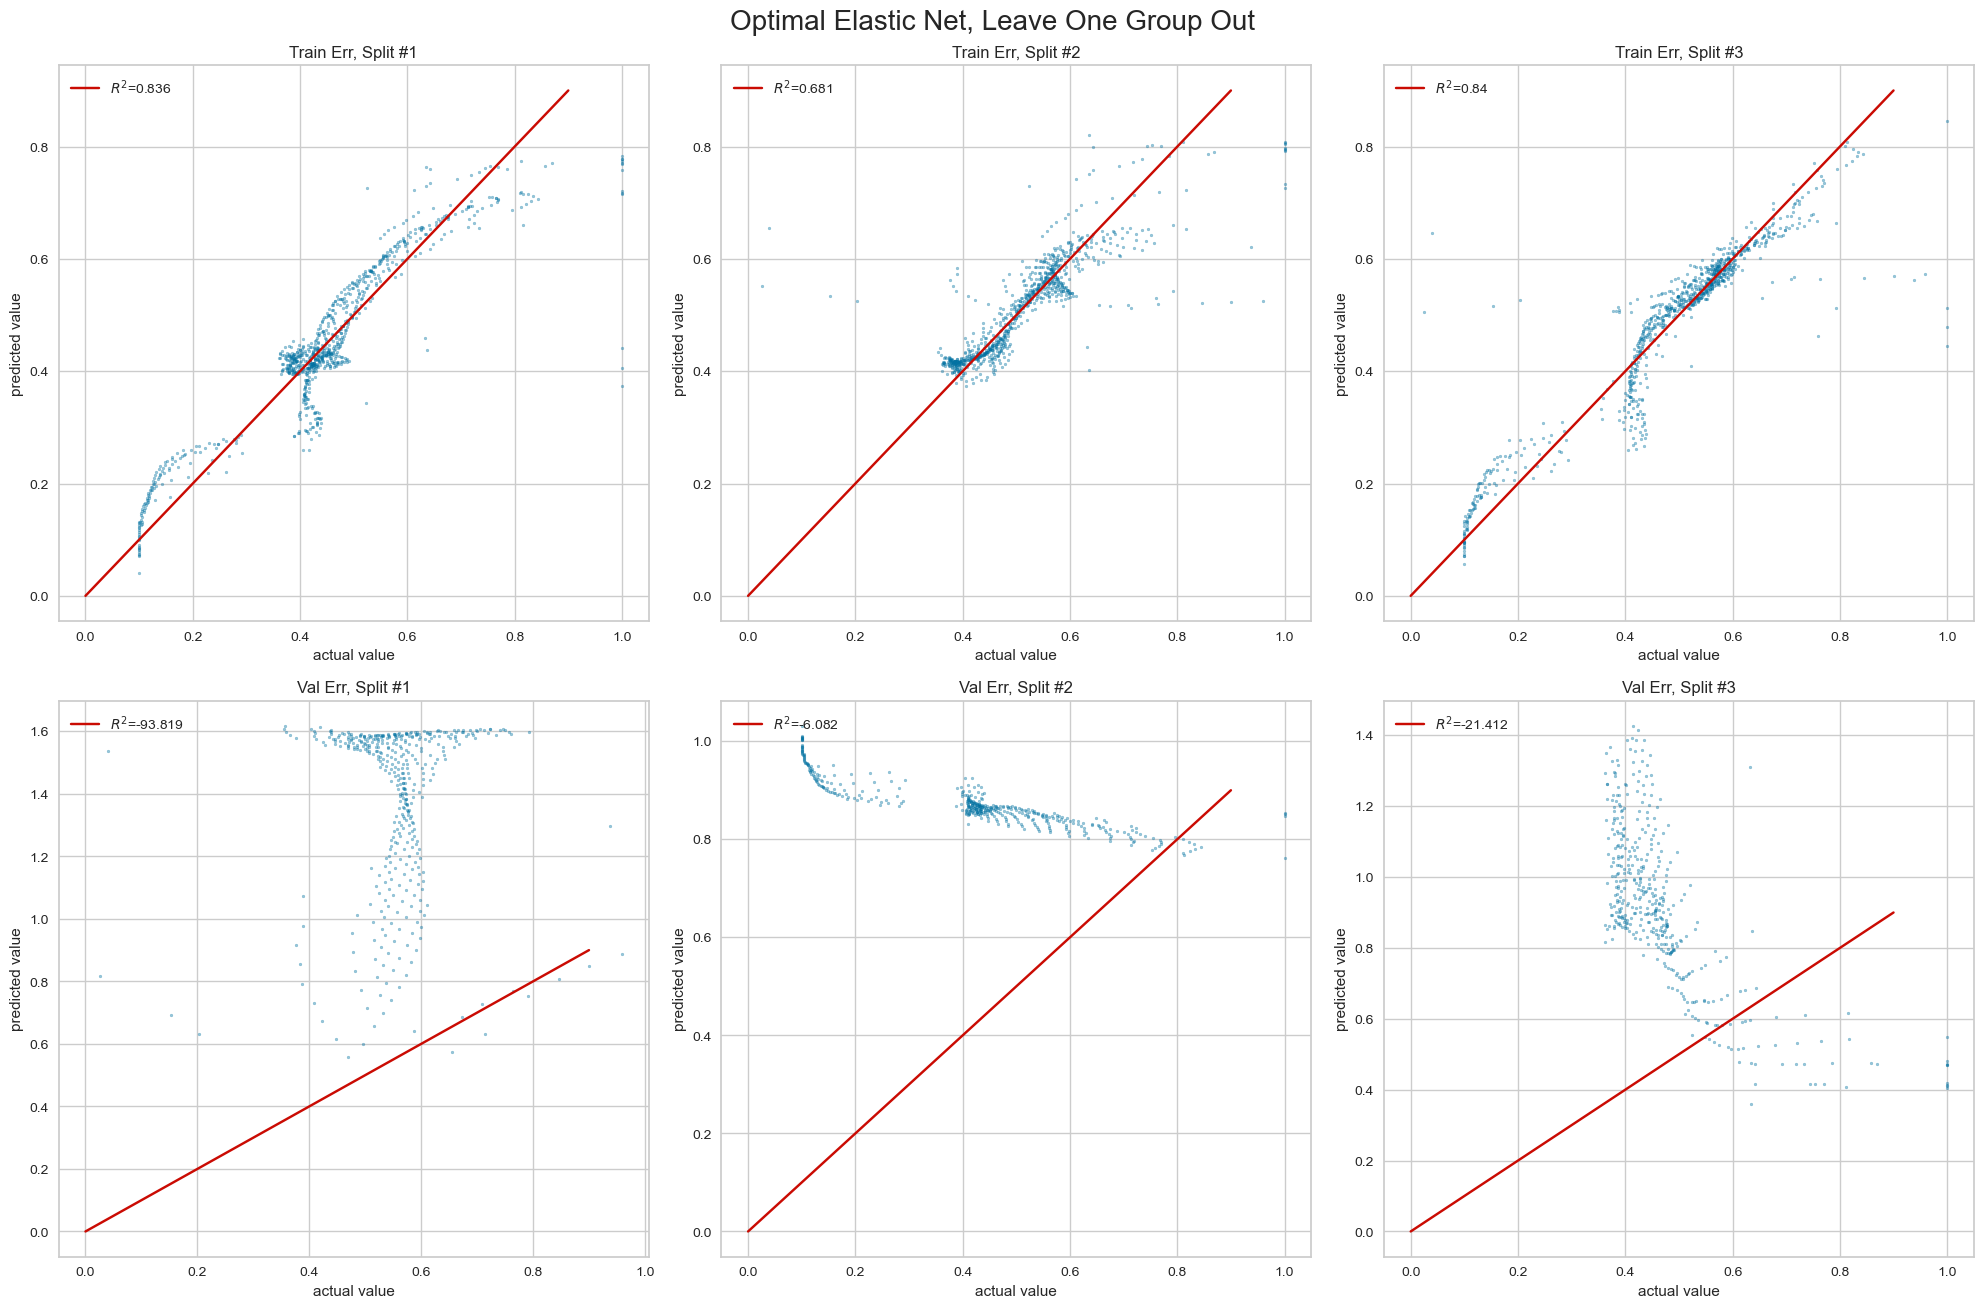

In [15]:
logo = LeaveOneGroupOut()

parity_plotCV(EN, X2, y, logo, cv_label=label ,title = 'Optimal Elastic Net, Leave One Group Out')

In [16]:
# train full data model (Elastic Net) with optimal alpha from before
opt_model = make_pipeline(StandardScaler(), EN).fit(X2, y)
# opt_model = EN.fit(X2_std, y) # EN is ready to go

/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.545e+00, tolerance: 3.016e-02
  model = cd_fast.enet_coordinate_descent(


### 4. Predict the FWHM in quaternary space

* generate compositions in quaternary space, then featurize

* select only the features used to train the optimal model

In [17]:
df2 = pd.DataFrame(columns = df.columns[:-2])

for Co in np.arange(0, 1, 0.05):
    for Ti in np.arange(0, 1-Co, 0.05):
        for Cr in np.arange(0, 1-Co-Ti, 0.05):
            row = pd.DataFrame({'Co': Co, 'Ti': Ti, 'Cr': Cr, 'Zr': 1-Co-Ti-Cr}, index=[0])
            df2 = pd.concat([df2, row], ignore_index = True)

In [18]:
# dff2 = df2.copy()
# dff2.insert(0, 'formula', 
#            'Co' + dff2['Co'].astype(str) + 'Ti' + dff2['Ti'].astype(str) + 
#            'Cr' + dff2['Cr'].astype(str) + 'Zr' + dff2['Zr'].astype(str))

# from matminer.featurizers.conversions import StrToComposition
# dff2 = StrToComposition().featurize_dataframe(dff2, 'formula')
# from matminer.featurizers.composition import Miedema, Meredig, WenAlloys, AtomicPackingEfficiency, ElectronegativityDiff
# from matminer.featurizers.composition import BandCenter, TMetalFraction, CohesiveEnergyMP, IonProperty

# dff2 = AtomicPackingEfficiency().featurize_dataframe(dff2, col_id='composition')
# dff2 = Miedema().featurize_dataframe(dff2, col_id='composition')
# dff2 = Meredig().featurize_dataframe(dff2, col_id='composition')
# dff2 = WenAlloys().featurize_dataframe(dff2, col_id='composition')

# dff2 = BandCenter().featurize_dataframe(dff2, col_id='composition')
# dff2 = TMetalFraction().featurize_dataframe(dff2, col_id='composition')

# dff2.to_excel('dff2.xlsx')

In [19]:
### similar to before, some basic data cleaning. 
dff2 = pd.read_excel('dff2.xlsx', index_col=0)

'''just for the purpose of plotting, data cleaning that remove rows are skipped
so that the two X have the same number of rows'''
# # record the row index of dff2 where Yang omega is greater than 100
# index = dff2[dff2['Yang omega'] > 100].index
# # drop the rows with Yang omega greater than 100 (in both featureized and unfeatureized df)
# dff2 = dff2.drop(index)

# # drop the rows with nan
# # dff2 = dff2.dropna()

# drop the column if the entire column is zero
dff2 = dff2.loc[:, (dff2 != 0).any(axis=0)]

# select only the features that are used in the model
features_reduced2 = dff2[features_reduced.columns]

In [20]:
# read npy files which come from assignment 5. Predict with the same function
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_test = np.load('X_test.npy')

from CustomFunctions import poly_predict
# here we use a linear regression by setting n_degree = 1
y_hat_poly, LR = poly_predict(X_train, y_train, X_test, n_degree=1, return_model = True)

X4 = features_reduced2.values 
# get the prediction
y_hat_EN = opt_model.predict(X4)

# join the two predictions together in a df
df_pred = pd.DataFrame({'Elastic Net': y_hat_EN, 'Polynomial': y_hat_poly})

df_pred = pd.concat([df2, df_pred], axis=1)

number of data point:  1549 
number of data point after removing unreasonable FWHM:  1484


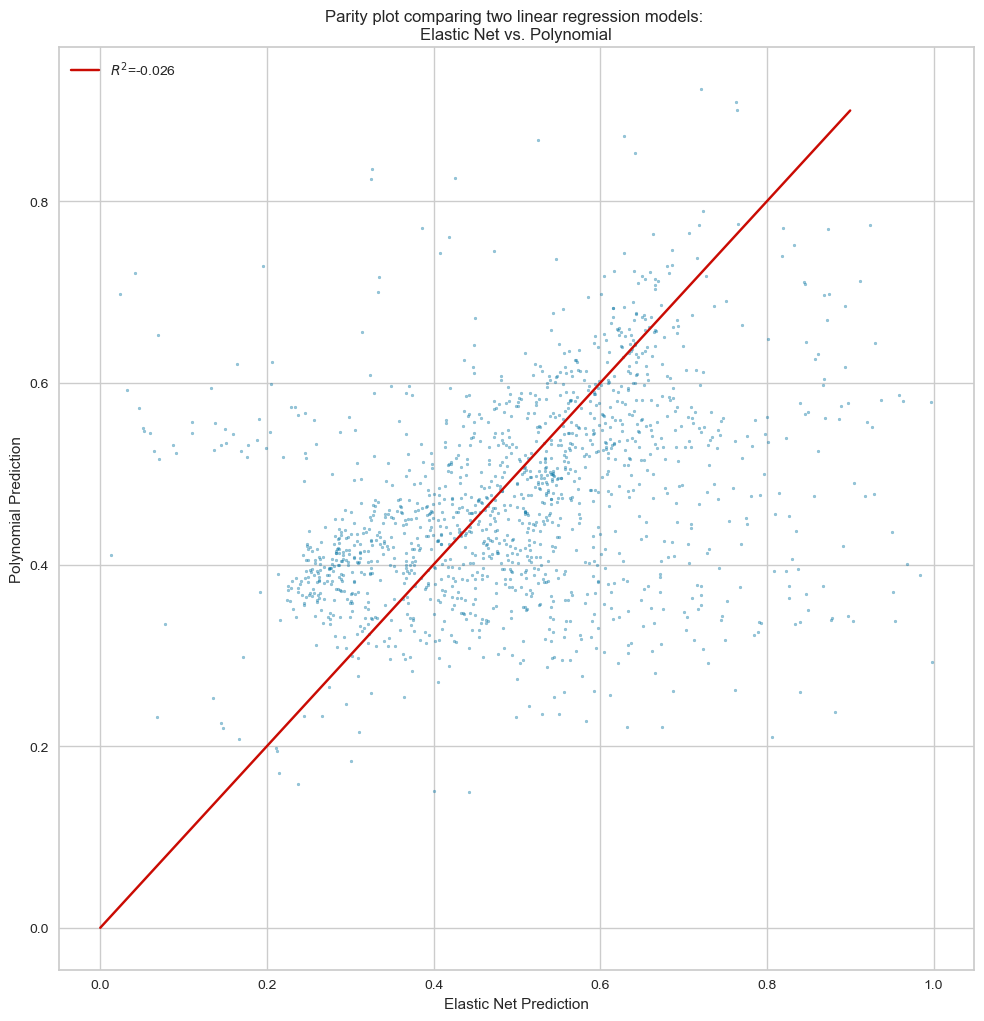

In [21]:
ini_len = len(df_pred)
# remove the row if the row contains a number greater than 1
# also remove the row if the row contains a number less than 0
df_pred = df_pred[(df_pred <= 1).all(1)]
df_pred = df_pred[(df_pred >= 0).all(1)]
after_len = len(df_pred)

print('number of data point: ', ini_len, 
      '\nnumber of data point after removing unreasonable FWHM: ', after_len)

# plot parity plot
from CustomFunctions import parity_plot
parity_plot(df_pred['Elastic Net'], df_pred['Polynomial'], xlabel = 'Elastic Net Prediction',
            ylabel = 'Polynomial Prediction', 
            title = 'Parity plot comparing two linear regression models: \nElastic Net vs. Polynomial')


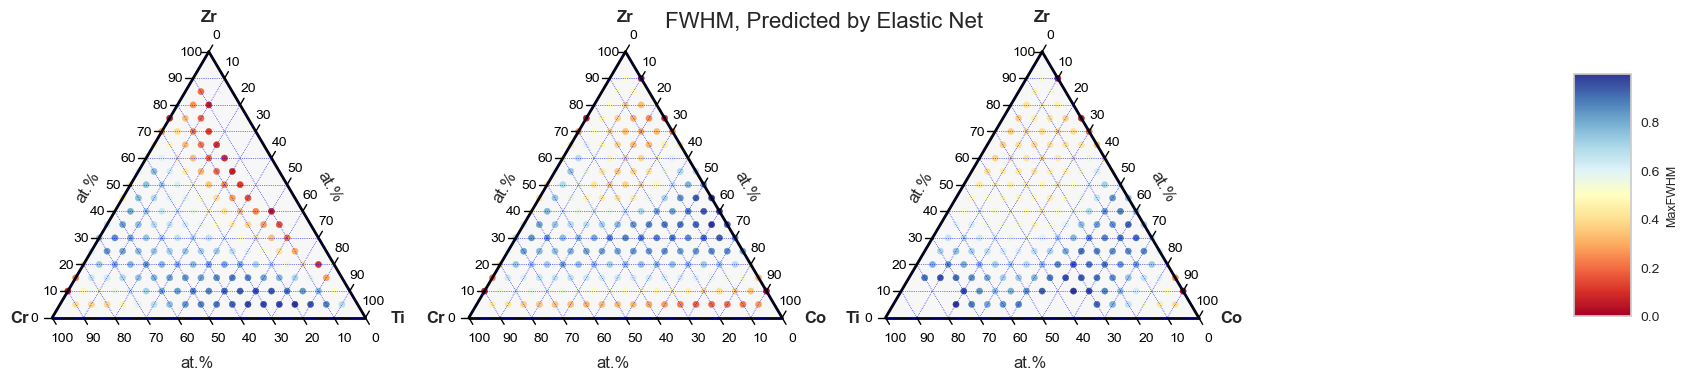

In [22]:
# set figure title
fig, axs = plt.subplots(1, 4, figsize = (17, 4))
fig.tight_layout(pad = 2.0)
fig.suptitle('FWHM, Predicted by Elastic Net', fontsize = 16)
for i, e in enumerate(missing):
    df_pred_copy = df_pred.copy()
    # in df_pred_copy, drop the rows where e is not 0
    df_pred_copy = df_pred_copy[df_pred_copy[e] == 0]
    # drop the column e
    df_pred_copy = df_pred_copy.drop(e, axis = 1)
    # plot ternary diagram
    ax = axs[i]
    df_plot_ternary(df_pred_copy, df_pred_copy.loc[:, 'Elastic Net'], 'MaxFWHM', ax = ax, cmap = plt.cm.RdYlBu)

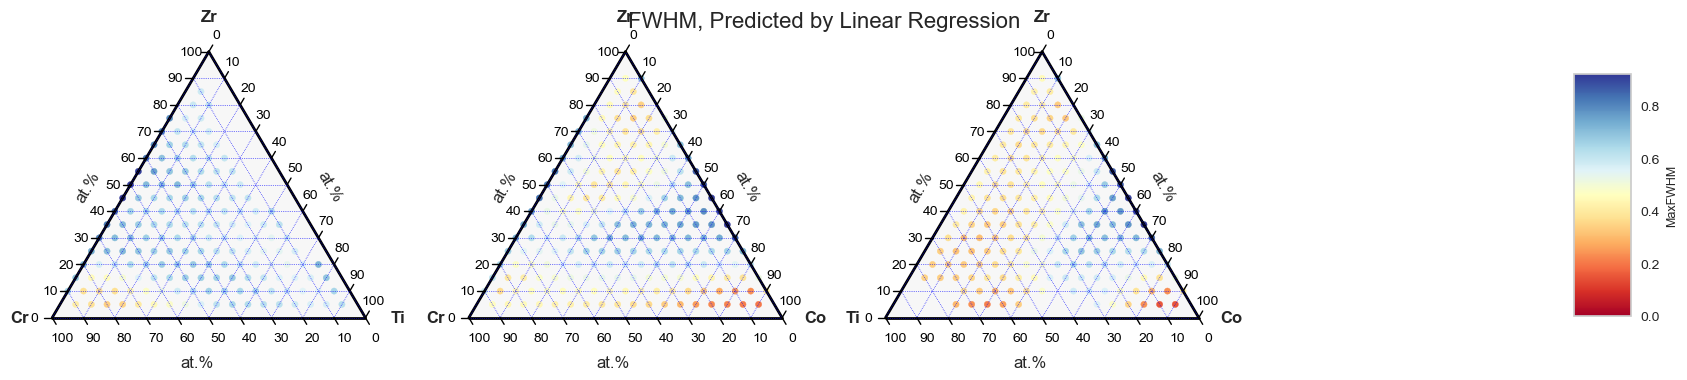

In [23]:
# also make one colored by the polynomial prediction

fig, axs = plt.subplots(1, 4, figsize = (17, 4))
fig.tight_layout(pad = 2.0)
fig.suptitle('FWHM, Predicted by Linear Regression', fontsize = 16)
for i, e in enumerate(missing):
    df_pred_copy = df_pred.copy()
    # in df_pred_copy, drop the rows where e is not 0
    df_pred_copy = df_pred_copy[df_pred_copy[e] == 0]
    # drop the column e
    df_pred_copy = df_pred_copy.drop(e, axis = 1)
    # plot ternary diagram
    ax = axs[i]
    df_plot_ternary(df_pred_copy, df_pred_copy.loc[:, 'Polynomial'], 'MaxFWHM', ax = ax, cmap = plt.cm.RdYlBu)

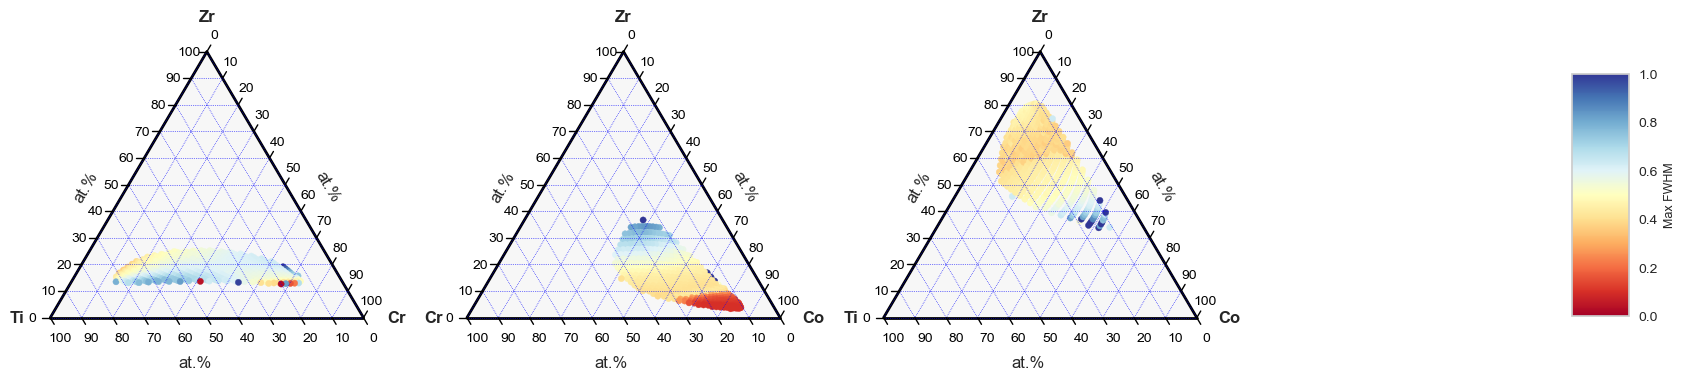

In [24]:
# compare with the actual FWHM in training set
fig, axs = plt.subplots(1, 4, figsize = (17, 4))
fig.tight_layout(pad = 2.0)

# create an empty dataframe with column names ['Co', 'Ti', 'Cr', 'Zr', 'MaxFWHM']
df = pd.DataFrame(columns = ['Co', 'Ti', 'Cr', 'Zr'])
### my own forloop
for i, e in enumerate(missing):
    sheet_df = pd.read_excel('Metallic Glass Data.xlsx', sheet_name = sheets[i]).dropna()
    
    # plotting 
    ax = axs[i]
    df_plot_ternary(sheet_df, sheet_df.loc[:, 'MaxFWHM'], 'Max FWHM', ax = ax, cmap = plt.cm.RdYlBu)
    
    #
    sheet_df[missing[i]] = 0
    sheet_df['tert_label'] = i
    df = pd.concat([df, sheet_df], ignore_index = True)

In [25]:
# let's see which features are most important
coef_EN = opt_model[-1].coef_
coef_df = pd.DataFrame(coef_EN, index = features_reduced.columns, columns = ['EN Coef'])
coef_df['EN Coef ABS'] = np.abs(coef_df['EN Coef'])

In [26]:
coef_df = coef_df.sort_values(by = 'EN Coef ABS', ascending = False); print('sort by Regularized model coefficient')
coef_df.head(15)

sort by Regularized model coefficient


,EN Coef,EN Coef ABS
Miedema_deltaH_inter,-0.323193,0.323193
Miedema_deltaH_ss_min,0.321591,0.321591
Radii local mismatch,-0.203475,0.203475
VEC mean,-0.117137,0.117137
Ti fraction,0.104586,0.104586
Electronegativity local mismatch,0.100887,0.100887
range AtomicRadius,0.083045,0.083045
Shear modulus local mismatch,0.065901,0.065901
Yang omega,-0.064494,0.064494
Shear modulus strength model,0.060464,0.060464


In [27]:
import pandas as pd
dff_assi5 = pd.read_excel('dff Assi 5.xlsx', index_col=0)
dff_assi5 = pd.DataFrame(columns=dff_assi5.columns[7:]).T
dff_assi5['LR Coef'] = LR.coef_.tolist()
dff_assi5['LR Coef ABS'] = np.abs(dff_assi5['LR Coef'])
dff_assi5

dff_assi5 = dff_assi5.sort_values(by = 'LR Coef ABS', ascending = False); print('sort by standard model coefficient')
dff_assi5

sort by standard model coefficient


,LR Coef,LR Coef ABS
Miedema_deltaH_inter,-0.453382,0.453382
Miedema_deltaH_ss_min,0.229163,0.229163
Miedema_deltaH_amor,0.146030,0.146030
Yang omega,0.043838,0.043838
dist from 5 clusters |APE| < 0.010,0.043517,0.043517
dist from 3 clusters |APE| < 0.010,-0.035497,0.035497
mean abs simul. packing efficiency,0.032406,0.032406
Yang delta,-0.013638,0.013638
mean simul. packing efficiency,-0.006130,0.006130
dist from 1 clusters |APE| < 0.010,-0.004005,0.004005


### Results:

Overall, the fits are similar in quality and predicted value. From the final phase diagram comparison, bothe models predicted FWHM that aligns well with the training data. The regulated model seem to have 'bolder' predictions, predicting FWHM with a larger variance, whereas the linear model is more reserved and predict FWHM close to the mean.

In general, the predictive power of both models are yet to be improved. Similar to the linear model, the regulated one also failed badly at Leave-one-cluster-out where a different ternary system is used to validate. 

In terms of feature importance, both model weight heavily on Miedema features **Miedema_deltaH_inter, Miedema_deltaH_ss_min**. Radii Local mismatch was correctly identified as one important feature, since in real life the factors include 
_https://uu.diva-portal.org/smash/get/diva2:1639228/FULLTEXT01.pdf_

1. more than 3 elements
2. at least 12% di erence in atomic radius. Relevant features: **Radii local mismatch, range AtomicRadius, Yang delta**
3. have a negative enthalpy of mixing (∆Hmix) among the constituents Relecant features: **Miedema_deltaH_inter, Miedema_deltaH_ss_min, Miedema_deltaH_amor, Yang omega**

Overall, very impressive identification of important features.